# Random Forest

In [ ]:
%pip install kagglehub numpy pandas seaborn matplotlib scikit-learn imbalanced-learn "ray[tune]"


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTENC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session

## Model From Scratch

In [18]:
import numpy as np

class DecisionNode:
  def __init__(self, impurity=None, feature_index=None, threshold=None, left=None, right=None):
    self.left = left
    self.right = right
    # The largest impurity value of this node
    self.impurity = impurity
    # Index of the feature which make the best fit for this node.
    self.feature_index = feature_index
    # The threshold value for that feature to make the split.
    self.threshold = threshold

class LeafNode:
  def __init__(self, value):
    self.prediction_value = value

class DecisionTreeClassifierFromScratch:
  def __init__(self, min_sample_split=3, min_impurity=1e-7, max_depth=10, criterion='gini'):
    self.root = None
    self.min_sample_split = min_sample_split
    self.min_impurity = min_impurity
    self.max_depth = max_depth
    self.impurity_function = self._claculate_information_gain
    if criterion == 'entropy':
      self.criterion = self._entropy
      self.criterion_name = criterion
    else:
      self.criterion = self._gini_index
      self.criterion_name = 'gini'

  def _gini_index(self, y):
    gini = 1
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      gini += -np.square(p)
    return gini

  def _entropy(self, y):
    entropy = 0
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      entropy += -p * np.log2(p)
    return entropy

  def _claculate_information_gain(self, y, y1, y2):
    # :param y: target value.
    # :param y1: target value for dataset in the true split/right branch.
    # :param y2: target value for dataset in the false split/left branch.

    # propobility of true values.
    p = len(y1) / len(y)
    info_gain = self.criterion(y) - p * self.criterion(y1) - (1 - p) * self.criterion(y2)
    return info_gain

  def _leaf_value_calculation(self, y):
    most_frequent_label = None
    max_count = 0
    unique_labels = np.unique(y)
    # iterate over all the unique values and find their frequentcy count.
    for label in unique_labels:
      count = len( y[y == label])
      if count > max_count:
        most_frequent_label = label
        max_count = count
    return most_frequent_label

  def _partition_dataset(self, Xy, feature_index, threshold):
    col = Xy[:, feature_index]
    X_1 = Xy[col >= threshold]
    X_2 = Xy[col < threshold]

    return X_1, X_2

  def _find_best_split(self, Xy):
    best_question = tuple()
    best_datasplit = {}
    largest_impurity = 0
    n_features = (Xy.shape[1] - 1)
    # iterate over all the features.
    for feature_index in range(n_features):
      # find the unique values in that feature.
      unique_value = set(s for s in Xy[:,feature_index])
      # iterate over all the unique values to find the impurity.
      for threshold in unique_value:
        # split the dataset based on the feature value.
        true_xy, false_xy = self._partition_dataset(Xy, feature_index, threshold)

        # skip the node which has any on type 0. because this means it is already pure.
        if len(true_xy) > 0 and len(false_xy) > 0:
          # find the y values.
          y = Xy[:, -1]
          true_y = true_xy[:, -1]
          false_y = false_xy[:, -1]
          # calculate the impurity function.
          impurity = self.impurity_function(y, true_y, false_y)

          # if the calculated impurity is larger than save this value for comaparition (highest gain).
          if impurity > largest_impurity:
            largest_impurity = impurity
            best_question = (feature_index, threshold)
            best_datasplit = {
              "leftX": true_xy[:, :n_features],   # X of left subtree
              "lefty": true_xy[:, n_features:],   # y of left subtree
              "rightX": false_xy[:, :n_features],  # X of right subtree
              "righty": false_xy[:, n_features:]   # y of right subtree
            }

    return largest_impurity, best_question, best_datasplit

  def _build_tree(self, X, y, current_depth=0):
    n_samples , n_features = X.shape
    # Add y as last column of X
    Xy = np.column_stack((X, y))
    # find the Information gain on each feature each values and return the question which splits the data very well
    if (n_samples >= self.min_sample_split) and (current_depth < self.max_depth):
      # find the best split/ which question split the data well.
      impurity, question, best_datasplit = self._find_best_split(Xy)
      if impurity > self.min_impurity:
        # Build subtrees for the right and left branch.
        true_branch = self._build_tree(best_datasplit["leftX"], best_datasplit["lefty"], current_depth + 1)
        false_branch = self._build_tree(best_datasplit["rightX"], best_datasplit["righty"], current_depth + 1)
        return DecisionNode(impurity=impurity, feature_index=question[0], threshold=question[1],
                            left=true_branch, right=false_branch)

    leaf_value = self._leaf_value_calculation(y)
    return LeafNode(value=leaf_value)

  def fit(self, X, y):
    self.root = self._build_tree(X, y, current_depth=0)

  def predict_sample(self, x, tree=None):
    if isinstance(tree , LeafNode):
      return tree.prediction_value

    if tree is None:
      tree = self.root
    feature_value = x[tree.feature_index]
    branch = tree.right

    if isinstance(feature_value, int) or isinstance(feature_value, float):
      if feature_value >= tree.threshold:
        branch = tree.left
    elif feature_value == tree.threshold:
      branch = tree.left

    return self.predict_sample(x, branch)

  def predict(self, test_X):
    x = np.array(test_X)
    y_pred = [self.predict_sample(sample) for sample in x]
    y_pred = np.array(y_pred)
    return y_pred

  def draw_tree(self):
    self._draw_tree(self.root)

  def _draw_tree(self, tree = None, indentation = " ", depth=0):
    if isinstance(tree , LeafNode):
      print(indentation,"The predicted value -->", tree.prediction_value)
      return
    else:
      print(indentation,f"({depth}) Is {tree.feature_index}>={tree.threshold}?"
            f": {self.criterion_name}:{tree.impurity:.2f}")
      if tree.left is not None:
          print (indentation + '----- True branch :)')
          self._draw_tree(tree.left, indentation + "  ", depth+1)
      if tree.right is not None:
          print (indentation + '----- False branch :)')
          self._draw_tree(tree.right, indentation + "  ", depth+1)

In [19]:
class RandomForestClassifierFromScratch:
    def __init__(
        self,
        max_feature=None,
        n_trees=100,
        min_sample_split=2,
        min_impurity=1e-7,
        max_depth=10,
        criterion="gini",
    ):
        # Initialize the trees.
        self.trees = []
        for _ in range(n_trees):
            self.trees.append(
                DecisionTreeClassifierFromScratch(
                    min_sample_split=min_sample_split,
                    min_impurity=min_impurity,
                    max_depth=max_depth,
                    criterion=criterion,
                )
            )

        self.tree_feature_indexes = []
        # Number of trees/estimetors.
        self.n_estimators = n_trees
        # How many features can be used for a tree from the whole features.
        self.max_features = max_feature
        # Aggication function to find the prediction.
        self.prediction_aggrigation_calculation = self._maximum_vote_calculation

    def _maximum_vote_calculation(self, y_preds):
        # Find which prediction class has higest frequency in all tree prediction for each sample.
        # create a empty array to store the prediction.
        y_pred = np.empty((y_preds.shape[0], 1))
        # iterate over all the data samples.
        for i, sample_predictions in enumerate(y_preds):
            y_pred[i] = np.bincount(sample_predictions.astype("int")).argmax()

        return y_pred

    def _make_random_subset(self, X, y, n_subsets, replacement=True):
        # Create a random subset of dataset with/without replacement.
        subset = []
        # use 100% of data when replacement is true , use 50% otherwise.
        sample_size = X.shape[0] if replacement else (X.shape[0] // 2)

        # Add y as last column of X
        Xy = np.column_stack((X, y))
        np.random.shuffle(Xy)
        # Select randome subset of data with replacement.
        for i in range(n_subsets):
            index = np.random.choice(
                range(sample_size),
                size=np.shape(range(sample_size)),
                replace=replacement,
            )
            X = Xy[index][:, :-1]
            y = Xy[index][:, -1]
            subset.append({"X": X, "y": y})
        return subset

    def fit(self, X, y):
        # if the max_features is not given then select it as square root of no on feature availabe.
        n_features = X.shape[1]
        if self.max_features == None:
            self.max_features = int(round(np.sqrt(n_features)))

        # Split the dataset into number of subsets equal to n_estimators.
        subsets = self._make_random_subset(X, y, self.n_estimators)

        for i, subset in enumerate(subsets):
            X_subset, y_subset = subset["X"], subset["y"]
            # select a random sucset of features for each tree. This is called feature bagging.
            idx = np.random.choice(
                range(n_features), size=self.max_features, replace=True
            )
            # track this for prediction.
            self.tree_feature_indexes.append(idx)
            # Get the X with the selected features only.
            X_subset = X_subset[:, idx]

            # change the y_subet to i dimentional array.
            y_subset = np.expand_dims(y_subset, axis=1)
            # build the model with selected features and selected random subset from dataset.
            self.trees[i].fit(X_subset, y_subset)

    def predict(self, test_X):
        y_preds = np.empty((test_X.shape[0], self.n_estimators))
        # find the prediction from each tree for each samples
        for i, tree in enumerate(self.trees):
            features_index = self.tree_feature_indexes[i]

            # test_X = (slice(None, None, None), array([8, 6, 0]))

            X_selected_features = test_X[:, features_index]
            if isinstance(tree, DecisionTreeClassifierFromScratch):
                y_preds[:, i] = tree.predict(X_selected_features).reshape((-1,))
            else:
                y_preds[:, i] = tree.predict(X_selected_features)
        # find the aggregated output.
        y_pred = self.prediction_aggrigation_calculation(y_preds)

        return y_pred

## Preprocessing

In [20]:
# select dataset
dataset_path = "../Breast_Cancer_Preprocessed.csv"
df = pd.read_csv(dataset_path)

# df.head()

"""
Techniques for highly unbalanced
97%
Decision Tree

raytune

https://www.kaggle.com/code/albertobircoci/decisiontree-randomforest#Models

https://www.kaggle.com/code/antoniosabatini/techniques-for-highly-unbalanced-data

5 Model 97%
https://www.kaggle.com/code/mohammedezzeldean/breast-cancer-prediction-5-models-97

https://www.kaggle.com/code/saeedeheydarian/recall-97-xgboost-and-randomforest
"""
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       4024 non-null   int64  
 1   Tumor Size                4024 non-null   int64  
 2   Estrogen Status           4024 non-null   int64  
 3   Progesterone Status       4024 non-null   int64  
 4   Regional Node Examined    4024 non-null   int64  
 5   Reginol Node Positive     4024 non-null   int64  
 6   Survival Months           4024 non-null   int64  
 7   Status                    4024 non-null   int64  
 8   T Stage Ordinal           4024 non-null   float64
 9   N Stage Ordinal           4024 non-null   float64
 10  M Stage Ordinal           4024 non-null   float64
 11  Differentiate Ordinal     4024 non-null   float64
 12  Marital Status_Divorced   4024 non-null   int64  
 13  Marital Status_Married    4024 non-null   int64  
 14  Marital 

In [21]:
# X = df.drop(columns=["Status_encoded"])
X = df[
    [
        "Progesterone Status",
        "N Stage Ordinal",
        "Differentiate Ordinal",
        "Race_Other",
        "Marital Status_Divorced",
    ]
]
y = df["Status"]

In [ ]:
# hyperparameters
# criterion = "gini"
# max_depth = 5
# min_samples_leaf = 4
# min_samples_split = 10
# n_estimators = 300

criterion = "entropy"
# max_depth = 5
# min_samples_leaf = 4
# min_samples_split = 10
n_estimators = 10

# n_trees = 100
# min_sample_split = 2
# min_impurity = 1e-7
# max_depth = 10
# criterion = "gini"

In [23]:
# RS = RandomOverSampler(random_state=42)
# X, y = RS.fit_resample(X, y)

In [24]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

alive_count = (y_test == 0).sum()
dead_count = (y_test == 1).sum()

print(f"number of alive patients: {alive_count}\nnumber of dead patients: {dead_count}")

number of alive patients: 685
number of dead patients: 120


In [25]:
# Grid Search
# Define hyperparameter grid for Random Forest
params = {
    "n_estimators": [100, 200, 300],          # number of trees
    "max_depth": [5, 10, 20, None],           # limit tree depth
    "min_samples_split": [2, 5, 10],          # split threshold
    "min_samples_leaf": [1, 2, 4],            # leaf threshold
    # "max_features": ["sqrt", "log2"],         # features per split
    "criterion": ["gini", "entropy"],         # impurity measure
}

# Define the Decision Tree model
model = RandomForestClassifier()

# grid_dt = GridSearchCV(model, params, cv=5, scoring="accuracy")
# grid_dt.fit(X_train, y_train)
# print("Best parameters:", grid_dt.best_params_)
# print("Best score:", grid_dt.best_score_)

# this took like 3 minutes
# Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
# Best score: 0.7857868020304568

In [26]:
# Oversampling
categorical_features = [
    X_train.columns.get_loc(c)
    for c in X_train.columns
    if "Marital Status" in c or "Race" in c
]


sm = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [27]:
rf = RandomForestClassifierFromScratch(n_trees=n_estimators, criterion=criterion)
# rf = RandomForestClassifierFromScratch(n_trees=n_estimators, min_sample_split=min_samples_split, max_depth=max_depth, criterion=criterion)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test.to_numpy())


## Evaluation

In [28]:
accuracy_score(y_test, y_pred)

0.7739130434782608

In [29]:
# NOTE: RandomForest isn't consistent, use the same model instead of training again
def predict(model):
    model.fit(X_train, y_train)
    model.predict(X_test.to_numpy())
    print(classification_report(model.predict(X_test.to_numpy()), y_test))

# predict(rf)

print(classification_report(rf.predict(X_test.to_numpy()), y_test))


              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       647
         1.0       0.40      0.30      0.35       158

    accuracy                           0.77       805
   macro avg       0.62      0.60      0.60       805
weighted avg       0.75      0.77      0.76       805



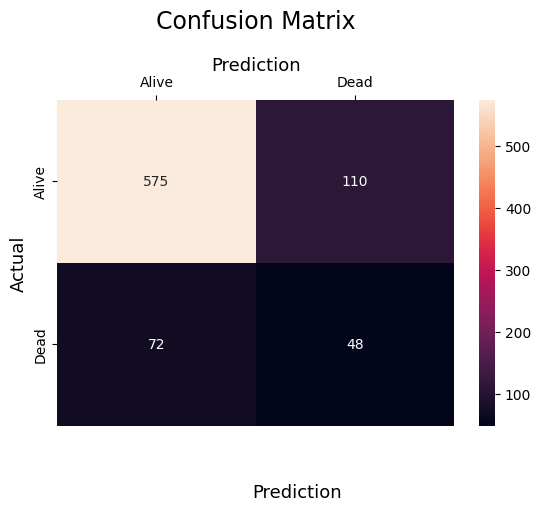

In [30]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 0 is alive and 1 is dead
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    xticklabels=["Alive", "Dead"],
    yticklabels=["Alive", "Dead"],
)
plt.ylabel("Actual", fontsize=13)
plt.title("Confusion Matrix", fontsize=17, pad=20)
plt.gca().xaxis.set_label_position("top")
plt.xlabel("Prediction", fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, "Prediction", ha="center", fontsize=13)
plt.show()

## Compare to scikit-learn

In [31]:
from sklearn.ensemble import RandomForestClassifier

Model_RF = RandomForestClassifier()
predict(Model_RF)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       622
           1       0.51      0.33      0.40       183

    accuracy                           0.78       805
   macro avg       0.67      0.62      0.63       805
weighted avg       0.75      0.78      0.76       805



/Users/gymmnotjim/Documents/[01]_PARA/[01]_Projects/university/intro_to_ai/intro-to-ml-and-dl-project/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/gymmnotjim/Documents/[01]_PARA/[01]_Projects/university/intro_to_ai/intro-to-ml-and-dl-project/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
